In [17]:
# ライブラリのインポート
from __future__ import absolute_import, division, print_function, unicode_literals

import itertools
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from PIL import Image
%matplotlib inline

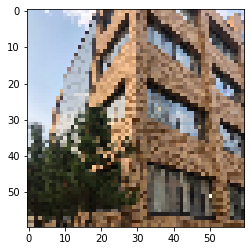

In [18]:
image_size = 60
image = Image.open('./train/図書館/51075722.76d59e28ec9259f2adf758fd4075b4f5.19121613.JPG')
image = image.convert("RGB")
image = image.resize((image_size, image_size))
data = np.asarray(image)
plt.imshow(data)

In [19]:
folder = [
          "4号棟",
          "ものつくり工房",
          "インタラクティブ棟",
          "ランゲージラウンジ",
          "食堂","図書館",
          "総合研究1号棟",
          "体育館",
          "銅像"
         ]

In [46]:
for index,name in enumerate(folder):
    dir = "./train/" + name
    files = glob.glob(dir + "/*.JPG")
    print(name, files[-1], len(files))


4号棟 ./train/4号棟/KIMG1101.JPG 141
ものつくり工房 ./train/ものつくり工房/IMG_4450.JPG 191
インタラクティブ棟 ./train/インタラクティブ棟/KIMG1209.JPG 182
ランゲージラウンジ ./train/ランゲージラウンジ/IMG_3071.JPG 99
食堂 ./train/食堂/51075716.f09662a35e9df5b3b13cd2469498f41c.19121709.JPG 147
図書館 ./train/図書館/51075722.5e39bb9a6674b90c0a92e2ef30c5505c.19121709.JPG 183
総合研究1号棟 ./train/総合研究1号棟/4620693218513701400.8b02a6c8b997188b5e677ae34b2038b2.19122006.JPG 110
体育館 ./train/体育館/IMG_4380.JPG 168
銅像 ./train/銅像/IMG_3922.JPG 124


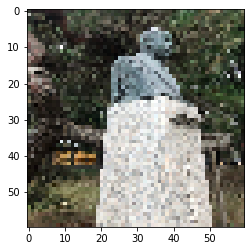

In [21]:
X = []
Y = []
for index, name in enumerate(folder):
    dir = "./train/" + name
    files = glob.glob(dir + "/*.JPG")
    for i, file in enumerate(files):
        if i > 100:
            break
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        plt.imshow(data)
        X.append(data)
        Y.append(index)

X = np.array(X, dtype=np.uint8)
Y = np.array(Y, dtype=int)

In [22]:
print(X.shape)
print(Y.shape)
Y[0]
Y = Y.reshape(-1,1)
print(Y.shape)
Y[0]

(907, 60, 60, 3)
(907,)
(907, 1)


array([0])

In [23]:
def cropping(img, x, y, px):
    #(x, y),(x+px, y),(x,y+px),(x+px, y+px)を四隅としてcrop
    cropped = img[x:x+px,y:y+px,:]
    #サイズを拡大　
    cropped = cv2.resize(cropped, (image_size, image_size))
    return cropped

In [24]:
def flip(img):
    #左右反転
    flipped = cv2.flip(img, 1)
    return flipped   

In [25]:
def preprocess(X, y):
    new_X = np.ndarray((0, image_size,image_size, 3),dtype=np.uint8)
    new_y = np.ndarray((0),dtype=int)
    for index, img in enumerate(X):
        
        #crop & flip
        for i, j in itertools.product(range(3), range(3)):
            cropped = cropping(img, i*4, j*4, 45)
            flipped = flip(cropped)
        
            new_X = np.concatenate([new_X, cropped.reshape(1,image_size,image_size,3), flipped.reshape(1,image_size,image_size,3)],axis=0)
            new_y = np.concatenate([new_y, y[index], y[index]],axis=0)
    
    #シャッフル
    cnt = new_X.shape[0]
    
    shuffle_array = np.arange(cnt)
    np.random.shuffle(shuffle_array)
    
    new_X = new_X[shuffle_array]
    new_y = new_y[shuffle_array]
    
    new_y = new_y.reshape(-1, 1)
            
    return new_X, new_y

In [26]:
X, Y = preprocess(X, Y)

In [27]:
X = X.astype('float32')
X = X / 255.0
print(X.shape)
print(Y.shape)

(16326, 60, 60, 3)
(16326, 1)


In [28]:
Y = np_utils.to_categorical(Y,len(folder))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [30]:
input_shape = (image_size,image_size,3)
epochs = 3
batch_size = 100

In [31]:
# モデルの定義
model = Sequential()

## ２次元畳み込み層１ 
model.add(Conv2D(filters=32, activation='relu', input_shape=input_shape, kernel_size=(3, 3), strides=(1, 1), padding='same'))

## ２次元畳み込み層２ 
model.add(Conv2D(filters=64, activation='relu', kernel_size=(3, 3), strides=(1, 1), padding='same'))

## maxプーリング層 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
## 全結合層１ 
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.50))

## 全結合層２ 
model.add(Dense(len(folder), activation='softmax'))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7372928   
____

In [35]:
# コンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), 
              metrics=['accuracy'])

In [36]:
# 学習
hist = model.fit(X_train,
                 y_train,
                 epochs=epochs,
                 validation_data=(X_test, y_test),
                 verbose=1,
                 batch_size=batch_size)

Train on 13060 samples, validate on 3266 samples
Epoch 1/3
13060/13060 [==============================] - 75s 6ms/sample - loss: 1.8317 - acc: 0.3299 - val_loss: 1.2786 - val_acc: 0.6087
Epoch 2/3
13060/13060 [==============================] - 76s 6ms/sample - loss: 1.2721 - acc: 0.5555 - val_loss: 0.9474 - val_acc: 0.7042
Epoch 3/3
13060/13060 [==============================] - 76s 6ms/sample - loss: 0.9987 - acc: 0.6472 - val_loss: 0.7058 - val_acc: 0.7673


In [37]:
hist.history

{'loss': [1.8316864943613866, 1.2720890946994332, 0.9987104138042806],
 'acc': [0.32986218, 0.555513, 0.6472435],
 'val_loss': [1.2785638059054278, 0.9473694153380993, 0.7058003993028523],
 'val_acc': [0.6086956, 0.70422536, 0.7672995]}

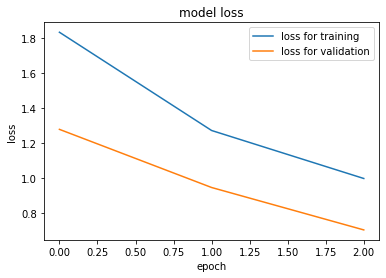

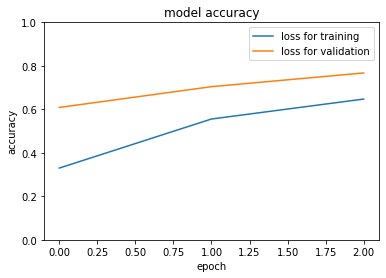

In [39]:
## 損失関数のグラフ(1点)
def plot_history_loss(hist):
    # hist.historyに辞書型で損失値や精度が入っているので取得して表示
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    
    #matplotlibの細かい設定
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    
    plt.show()
    

##　精度のグラフ(1点)
## tf2.0では'acc'ではなく'accuracy'なので注意
def plot_history_acc(hist):
    plt.plot(hist.history['acc'],label="loss for training")
    plt.plot(hist.history['val_acc'],label="loss for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

plot_history_loss(hist)
plot_history_acc(hist)

In [40]:
#評価 & 評価結果出力
print(model.evaluate(X_test, y_test))

3266/3266 [==============================] - 4s 1ms/sample - loss: 0.7058 - acc: 0.7673
[0.705800399193352, 0.7672995]


In [41]:
# モデルの保存
open('and.json',"w").write(model.to_json())

# 学習済みの重みを保存
model.save_weights('and_weight.hdf5')